In [18]:
import os
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [19]:
def get_plot_data(results, grouby='acc_test_best'):
  d = {}
  d['num_sample'] = []
  d['acc_valid_best'] = []
  d['acc_test_best'] = []
  for result in results:
    num_sample = result['num_unique_sample']
    acc_valid = result['acc_valid']
    acc_test = result['acc_test']
    index_unique_sample = result['index_unique_sample']
    index_pred_top = result['index_pred_top']
    for i in range(len(index_unique_sample)):
      d['num_sample'].append(num_sample[i])
      d['acc_valid_best'].append(max(np.max(acc_valid[index_unique_sample[i]]),acc_valid[index_pred_top[i][0]]))
      d['acc_test_best'].append(max(np.max(acc_test[index_unique_sample[i]]),acc_test[index_pred_top[i][0]]))

  run = len(results)
  df = pd.DataFrame(data=d)
  grouped = df[grouby].groupby(df['num_sample'])
  est = grouped.agg("mean")
  sd = grouped.std()
  sd = sd.fillna(value=0)
  cis = pd.DataFrame(np.c_[est - sd, est + sd], index=est.index, columns=["low", "high"]).stack()
  if cis.notnull().any():
      cis = cis.unstack().reindex(est.index)
  else:
      cis = None
  x, y = np.asarray(est.index), np.asarray(est)
  low, high = np.asarray(cis["low"]), np.asarray(cis["high"])
  std = np.asarray(sd)
  plot_data={"x":x,"y":y,'var':std}
  return plot_data

def draw_baseline(ax, data_dict):
  for key, value in data_dict.items():
    p = ax.plot(value["x"], value["y"], label=key)
    if "var" in value:
      ax.fill_between(value["x"], value["y"] - value["var"], value["y"] + value["var"], alpha=0.1, color=p[0].get_color(), edgecolor=None)
  return ax

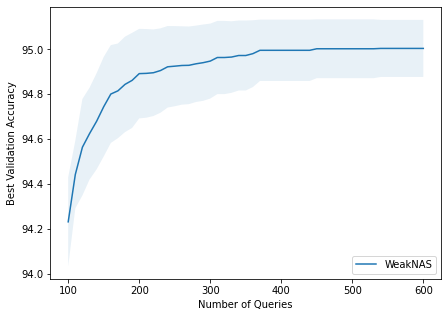

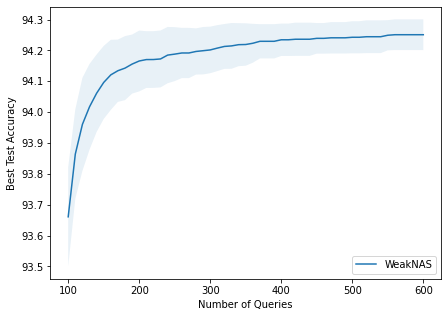

In [20]:
base_dir = 'OUTPUT/charles-09-13-nasbench-101-mlp' # modify base_dir to log path
exp_dict = {'WeakNAS':
            'nasbench101/init_100_sample_10/top_start_100_end_100/MLP/onehot_size_1000_1000_1000_1000_iter_100/acq_uniform/deter_False',
           'WeakNAS (EI Variant)':
            'nasbench101/init_100_sample_10/top_start_100_end_100/MLP/onehot_size_1000_1000_1000_1000_iter_100/acq_ei/deter_False',}
for key, value in exp_dict.items():
  exp_dict[key] = os.path.join(base_dir, value)
  
data_dict = {}
for key, exp_dir in exp_dict.items():
  files = [os.path.join(exp_dir, f) for f in os.listdir(exp_dir)]
  results = []
  for file in files:
    with open(file, 'rb') as f:
      results.append(pickle.load(f))
  data_dict[key] = get_plot_data(results, grouby='acc_valid_best')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), facecolor='white')
ax.set_facecolor(color=(1.0, 1.0, 1.0, 0.0))
ax = draw_baseline(ax, data_dict)
ax.set_ylabel('Best Validation Accuracy')
ax.set_xlabel('Number of Queries')
leg = ax.legend(loc='lower right')

final_archs = {}
data_dict = {}
for key, exp_dir in exp_dict.items():
  files = [os.path.join(exp_dir, f) for f in os.listdir(exp_dir)]
  results = []
  for file in files:
    with open(file, 'rb') as f:
      results.append(pickle.load(f))
  data = get_plot_data(results, grouby='acc_test_best')
  data_dict[key] = data
  
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), facecolor='white')
ax.set_facecolor(color=(1.0, 1.0, 1.0, 0.0))
ax = draw_baseline(ax, data_dict)
ax.set_ylabel('Best Test Accuracy')
ax.set_xlabel('Number of Queries')
leg = ax.legend(loc='lower right')

In [23]:
# Table 1, 3
value = data_dict['WeakNAS']
print(f'100 Queries, Test Acc:{value["y"][np.where(value["x"]==100)][0]:.02f}')
print(f'150 Queries, Test Acc:{value["y"][np.where(value["x"]==150)][0]:.02f}') 
print(f'200 Queries, Test Acc:{value["y"][np.where(value["x"]==200)][0]:.02f}')
# print(f'1000 Queries, Test Acc:{value["y"][np.where(value["x"]==1000)][0]:.02f}')

100 Queries, Test Acc:93.66
150 Queries, Test Acc:94.10
200 Queries, Test Acc:94.17
